###

##### STAC APIを用いて衛星データ取得＋ NDVI 計算
##### Using the STAC API to obtain satellite data and compute NDVI

Set GPU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 21.5 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/pystac_client/item_search.py:925: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Item found: S2A_MSIL2A_20230805T012701_R074_T54SUE_20240907T133450


/tmp/ipython-input-3048434375.py:64: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


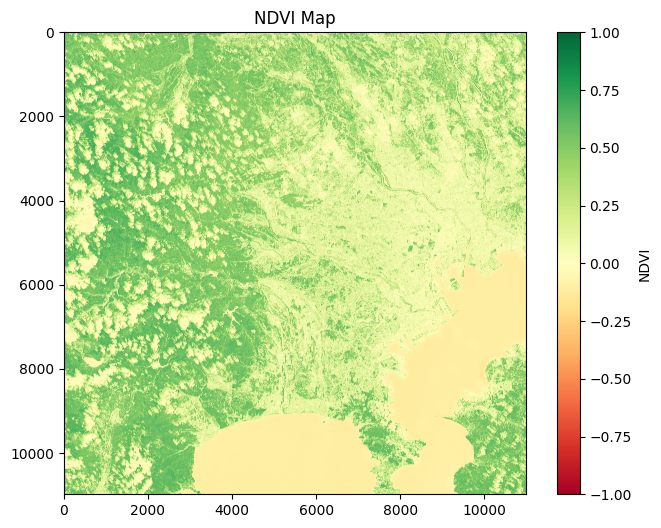

In [1]:
# ライブラリをインストール
# Install required libraries
!pip install pystac-client planetary-computer rasterio matplotlib numpy

# ライブラリのインポート
# Import libraries
import pystac_client
import planetary_computer
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# STAC APIに接続
# Connect to STAC API
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# 検索条件を指定（例: Sentinel-2, 特定地域, 日付範囲）
# Define search parameters (e.g., Sentinel-2, specific area, date range)
from shapely.geometry import box
import geopandas as gpd

# 例として日本の緯度経度で矩形領域を作成
# Create a bounding box for a region in Japan
bbox_geom = box(139.70, 35.65, 139.80, 35.70)  # 東京近辺/around Tokyo
bbox = [139.70, 35.65, 139.80, 35.70]

search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime="2023-08-01/2023-08-31",
    query={"eo:cloud_cover": {"lt": 10}},  # 雲量10%以下/Cloud cover less than 10%
    max_items=1
)

items = list(search.get_items())

if not items:
    print("No items found")
else:
    item = items[0]
    print("Item found:", item.id)

# NDVI計算用にバンドを取得
# Get bands for NDVI calculation
item_signed = planetary_computer.sign(item)  # データへの署名/Signature on data
red_url = item_signed.assets['B04'].href
nir_url = item_signed.assets['B08'].href

with rasterio.open(red_url) as red_src:
    red = red_src.read(1).astype('float32')

with rasterio.open(nir_url) as nir_src:
    nir = nir_src.read(1).astype('float32')

# NDVI計算
# Calculate NDVI
ndvi = (nir - red) / (nir + red)

# NDVI表示
# Display NDVI
plt.figure(figsize=(8,6))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.title("NDVI Map")
plt.show()
